<a href="https://www.kaggle.com/code/shivansh2503/image-compression?scriptVersionId=249136221" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
import torch
import torch.nn as nn
import math 

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/architecture/arch.png
/kaggle/input/image1/may.jpeg
/kaggle/input/apples/apple.jpg


In [2]:
img = Image.open("/kaggle/input/apples/apple.jpg")
print("Image Size: ",img.size)
print("Image Mode: ",img.mode)
print("Image Dimmensions: ", np.array(img).shape)

Image Size:  (998, 1000)
Image Mode:  RGB
Image Dimmensions:  (1000, 998, 3)


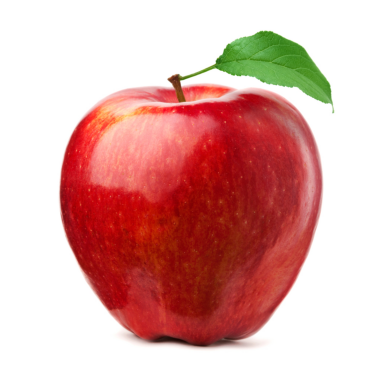

In [3]:
plt.imshow(img)
plt.axis("off")
plt.show()

In [4]:
# converting to grayscale for faster execution
img_grayscale = img.convert("L")
print("Gray Scale Image Size: ",img_grayscale.size)  #(width, height)
print("Gray Scale Image Mode: ",img_grayscale.mode)
print("Gray Scale Image Dimmensions: ", np.array(img_grayscale).shape) #(height, width)

Gray Scale Image Size:  (998, 1000)
Gray Scale Image Mode:  L
Gray Scale Image Dimmensions:  (1000, 998)


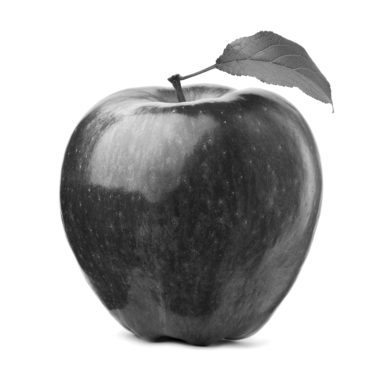

In [5]:
plt.imshow(img_grayscale, cmap="gray")
plt.axis("off")
plt.show()

## Pre processing

### For normalization we using the min,max normalizatoin instead of sklearn because sklearn normalizes rows by their L2 norm and That’s for feature vectors, not pixel values.
$$
X_{\text{normalized}} = (X - \text{min\_val}) \times \frac{(\text{new\_max} - \text{new\_min})}{(\text{max\_val} - \text{min\_val})} + \text{new\_min}
$$

### For 8 bit grayscale image min value = 0, max value = 255 and the target range is [-1, 1] for sin functions to be used therefore new_min = -1, new_max=1

$$
X_{\text{normalized}} = (X - 0) \times \frac{(1 - (-1))}{(255 - 0)} + (-1)
$$

$$
X_{\text{normalized}} = \left(\frac{X}{255}\right) \times 2 - 1
$$

### Hence this formula we'll be using to normalize.

In [6]:
# Converting grayscale image into pixels
image_np = np.array(img_grayscale)

#normalising the image
pixels = (image_np/255.0)*2 -1
print("Initial Shape: ",pixels.shape)

pixels_reshape = pixels.reshape(-1,1)
print("Now Shape: ", pixels_reshape.shape)

Initial Shape:  (1000, 998)
Now Shape:  (998000, 1)


In [7]:
H, W = image_np.shape

x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)

xx, yy = np.meshgrid(x,y, indexing="xy")

coords = np.stack([xx, yy],axis=-1).reshape(-1, 2)

X = torch.tensor(coords, dtype = torch.float32) # Coordinates flatten -> Given as input to siren
Y = torch.tensor(pixels_reshape, dtype = torch.float32) # GT used for MSE and Back propogation MSE(Y', Y)

## Model building

### Concept i followed
    nn.Linear → Sine Activation → nn.Linear → Sine → ... → Final Output
1. Since i'm using a custom AF, so i am required to have custom weight initialization as well, as He and Xavior are Relu/Tanh optimizied

In [8]:
# Creating sine activation function 
class sine_af(nn.Module):
    def __init__(self, w0 = 1):
        super().__init__()
        self.w0 = w0


    def forward(self, x):
        return torch.sin((self.w0)*x)

### This frequency term follow a very very important role in this SIREN, instead of using directly
$$sin(x)$$ 
### which converges lately for higher signals we add a frequency w0 to make it converge faster and capture high details
$$ sin(ω₀ * x) $$
### Also sins are infinitely differentiable thus allowing SIRENs to capture the detials even at 1st and 2nd derivatives which Relu and Tanh suffered from.
### Also adding w0 solves the problem of diminishing gradient or vanishing gradient, as 
$$ y = sin(ω₀ * x)$$
$$
\frac{dy}{dx} = \omega_0 \cdot \cos(\omega_0 \cdot x)
$$
        
                                                                         and
$$
\frac{d^2y}{dx^2} = -\omega_0^2 \cdot \sin(\omega_0 \cdot x)
$$

### So If ω₀ is large (like 30), the magnitude of the gradient (derivative) is also scaled up by ω₀.

### While a Sine AF could map to [-1, 1], a linear output layer is standard for regression tasks because it offers maximum flexibility. The network's capacity to learn the [-1, 1] range (or any other target range) comes from the preceding layers and the training process, not from a final output activation function. Therefore we haven't applied sine af to the final layer

In [9]:
def siren_self_weights(layer, is_first_layer = False, w0_initial = 30.0):
    if isinstance(layer, nn.Linear):
        fan_in = layer.in_features
    
        if is_first_layer:
            limit = 1/ fan_in
    
        else:
            limit = (math.sqrt(6/fan_in))/w0_initial
    
        layer.weight.data.uniform_(-limit, limit)
        layer.bias.data.fill_(0)

# def siren_init_(layer, is_first_layer=False, w0_initial=30.0, c=6):
#     if isinstance(layer, nn.Linear):
        
#         fan_in = layer.weight.size(1)
#         if is_first_layer:
#             limit = math.sqrt(c / fan_in) / w0_initial
#         else:
#             limit = math.sqrt(c / fan_in)
#         layer.weight.data.uniform_(-limit, limit)
#         layer.bias.data.fill_(0)

In [10]:
class Siren(nn.Module):
    def __init__(self, inputs,hidden_features, hidden_layers, output_number, frequency_initial = 30, frequency = 1):
        super(Siren, self).__init__()

        self.lists = []
    
        # First Layer
        first_layer = nn.Linear(inputs, hidden_features)
        siren_self_weights(first_layer, is_first_layer = True, w0_initial = frequency_initial)
        self.lists.append(first_layer)
        # applying AF
        self.lists.append(sine_af(w0 = frequency_initial))
    
        # Hidden Layers
        for hidden_layer in range(hidden_layers):
            
            layer = nn.Linear(hidden_features, hidden_features)
            siren_self_weights(layer, is_first_layer=False, w0_initial = frequency)
            self.lists.append(layer)
            # Applying AF
            self.lists.append(sine_af(w0 = frequency))

        # Final layer
        final_layer = nn.Linear(hidden_features, output_number)
        siren_self_weights(final_layer, is_first_layer = False, w0_initial = frequency)
        self.lists.append(final_layer)

        self.net = nn.Sequential(*self.lists)


    def forward(self, x):
        return self.net(x)

In [11]:
model = Siren(inputs=2, hidden_features=256, hidden_layers=3, output_number=1,
              frequency_initial=30, frequency=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [12]:
# --- Move model and data to GPU if available ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Siren(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): sine_af()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): sine_af()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): sine_af()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): sine_af()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [13]:
X = X.to(device)
Y = Y.to(device)

In [14]:
print(f"X tensor is on: {X.device}")
print(f"Y tensor is on: {Y.device}")

X tensor is on: cuda:0
Y tensor is on: cuda:0


In [15]:
# num_epochs = 1000
# losses = []

# print("Training started")
# # Training Loop
# for epoch in range(num_epochs):
#     model.train()
#     optimizer.zero_grad()

#     # Forward Pass
#     outputs = model(X)

#     # Compute Loss
#     loss = criterion(outputs, Y)
#     losses.append(loss.item())

#     # Backward + Optimize
#     loss.backward()
#     optimizer.step()

#     #logging
#     if (epoch + 1) % 100 == 0: # Print loss every 100 epochs
#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

# print("Training finished!")

In [16]:
# plt.plot(losses)
# plt.title("Training Loss over Epochs")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.grid()
# plt.show()

In [17]:
# model.eval()  # Set model to eval mode (very important)

# with torch.no_grad():
#     preds = model(X.to(device)).cpu().numpy()


In [18]:
# output_image = preds.reshape(H, W)

In [19]:
# output_image = ((output_image + 1) / 2.0) * 255
# output_image = np.clip(output_image, 0, 255).astype(np.uint8)

In [20]:
# plt.figure(figsize=(10,5))

# # Ground truth
# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(image_np, cmap="gray")
# plt.axis("off")

# # Reconstructed
# plt.subplot(1, 2, 2)
# plt.title("Reconstructed by SIREN")
# plt.imshow(output_image, cmap="gray")
# plt.axis("off")

# plt.show()

In [21]:
# def psnr(original, reconstructed):
#     mse = np.mean((original - reconstructed) ** 2)
#     if mse == 0:
#         return float('inf')
#     PIXEL_MAX = 255.0
#     return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

# print("PSNR:", psnr(image_np, output_image))